In [1]:
# -*- coding: utf-8 -*-
"""
@author: Etienne Kras
"""
# imports 
import numpy as np
import matplotlib.pyplot as plt
import os
import geopandas as gpd
import pandas as pd
import contextily as ctx
import geojson
import xarray as xr
import rasterio
import scipy.stats
import itertools

# specific imports
from shapely.geometry import Polygon, LineString, Point
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.neighbors import KDTree
from osgeo import osr
from operator import itemgetter
from sklearn import metrics

%matplotlib widget

# TODO: use dfm_tool funcs for ldb?
# TODO: clean up script

C:\Users\kras\AppData\Local\Temp\ipykernel_15916\1048634648.py:9: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


# Project specific toggles

In [34]:
# project toggles
main_fol = r"p:/11208561-he11-abu-dhabi/6_satellite_bathymetry" # name of the main local folder 
data_fol = r"p:/11208561-he11-abu-dhabi/1_data" # data folder
input_fol = "SDB" # name of the input folder
mode = "intertidal" # specify mode, either "intertidal" or "subtidal"
project_name = 'Hudayriat' # name of the project AoI

# composite image toggles
scale = 10 # input resolution of the image [m]
zoom_level = "" # selected zoom level or leave empty in case of an arbitrary polygons

# tidal information (project input)
tide_inds = [-1.14, -0.64, -0.14, 0.06, 0.26, 0.76, 1.26] # m, [LAT, MLLW, (MHLW), MSL, (MLHW), MHHW, HAT]

# Post-processing

In [3]:
# open AoI
with open(os.path.join(main_fol, "AOI", project_name + ".geojson"), 'r') as f:
    contents = geojson.loads(f.read())
AoI = LineString(contents["features"][0]["geometry"]["coordinates"])
gdf_aoi = gpd.GeoDataFrame(geometry=[Polygon(AoI)], crs="epsg:4326")

In [39]:
# open bathy file
#check_file = pd.read_table(os.path.join(data_fol, r"DO_NOT_USE_OR_DISTRIBUTE\Bayanat_survey_2013 (not complete)\corniche_DOT_wgs84geo.xyz"), delim_whitespace=True, names=['x', 'y', 'z']) # subset
#check_file = pd.read_table(os.path.join(data_fol, r"DO_NOT_USE_OR_DISTRIBUTE\Bayanat_survey_2013 (not complete)\ALL_UAE1007-1015_WGS84Geo.xyz"), delim_whitespace=True, names=['x', 'y', 'z']) # all points
check_file = pd.read_table(os.path.join(data_fol, r"1_from_Parsons/recd_20230324_Bathymetry survey\bathymetry_H_E11_geowgs_NADD.xyz"), delim_whitespace=True, names=['x', 'y', 'z']) # all points
gdf_is = gpd.GeoDataFrame(check_file, crs="epsg:4326", geometry=gpd.points_from_xy(check_file.x, check_file.y))

In [47]:
gdf_is

,x,y,z,geometry
0,54.357691,24.418175,2.33,POINT (54.35769 24.41818)
1,54.357697,24.418184,2.33,POINT (54.35770 24.41818)
2,54.357702,24.418192,2.33,POINT (54.35770 24.41819)
3,54.357707,24.418202,2.33,POINT (54.35771 24.41820)
4,54.357711,24.418213,2.34,POINT (54.35771 24.41821)
...,...,...,...,...
162709,54.359926,24.417360,2.47,POINT (54.35993 24.41736)
162710,54.359929,24.417363,2.47,POINT (54.35993 24.41736)
162711,54.359932,24.417366,2.48,POINT (54.35993 24.41737)
162712,54.359938,24.417373,2.48,POINT (54.35994 24.41737)


In [54]:
# filter in-situ data on AoI
gdf_is_fil = gpd.sjoin(gdf_is, gdf_aoi).reset_index(drop=True)

# get rid of the points outside of the intertidal range
gdf_is_fil2 = gdf_is_fil[gdf_is_fil.z < tide_inds[-1]].reset_index(drop=True)
gdf_is_fil3 = gdf_is_fil2[gdf_is_fil2.z > tide_inds[0]].reset_index(drop=True)

# reproject the in-situ data
gdf_is_fil_tsp = gdf_is_fil3.to_crs("epsg:3857")

In [58]:
# TODO: mask layer with ldb or with layer itself (as possible with water mask from SDB subtidal)
# open LDB file
with open(os.path.join(data_fol, r"2_inhouse\DO_NOT_USE_OR_DISTRIBUTE\Bayanat_survey_2013 (not complete)\ag_wgs84geo_Apr2021_v2a_closed.ldb")) as f:
    lines = f.read().splitlines()

# data preperation
ldb_pol = []
counter = -1
for idx, i in enumerate(lines[5:]): # skip the header
    if i == "*": continue
    if i.startswith("L"): # marks a line, create a sublist and add to counter
        ldb_pol.append([]) # make sublist
        counter += 1 # identify index of created sublist
        linfo = idx+1 # identify index of information on coordinates in line element
    if idx != linfo and not i.startswith("L"): # only append line coords
        ldb_pol[counter].append([float(j) for j in i.lstrip().split("   ")])

# make geodataframe
#ldb_pols = [Polygon(i) for i in ldb_pol]
ldb_pols = []
for idx, i in enumerate(ldb_pol):
    if Polygon(i).area > 5: # make the large polygon an outer polygon (arbitrary value)
        ls = i[0:-2] # get rid of last duplicate point

        # add 4 points to make the outer polygon land area (note now added good order manually)
        ls_unz = list(zip(*ls))
        ll = [np.min(ls_unz[0]), np.min(ls_unz[1])] 
        ur = [np.max(ls_unz[0]), np.max(ls_unz[1])] 
        ul = [np.min(ls_unz[0]), np.max(ls_unz[1])]
        lr = [np.max(ls_unz[0]), np.min(ls_unz[1])] 
        ls.append(lr), ls.append(ll), ls.append(ul), ls.append(ur) 
        ldb_pols.append(Polygon(ls))
    else:
        ldb_pols.append(Polygon(i))
gdf_ldb = gpd.GeoDataFrame(geometry=ldb_pols, crs="epsg:4326")

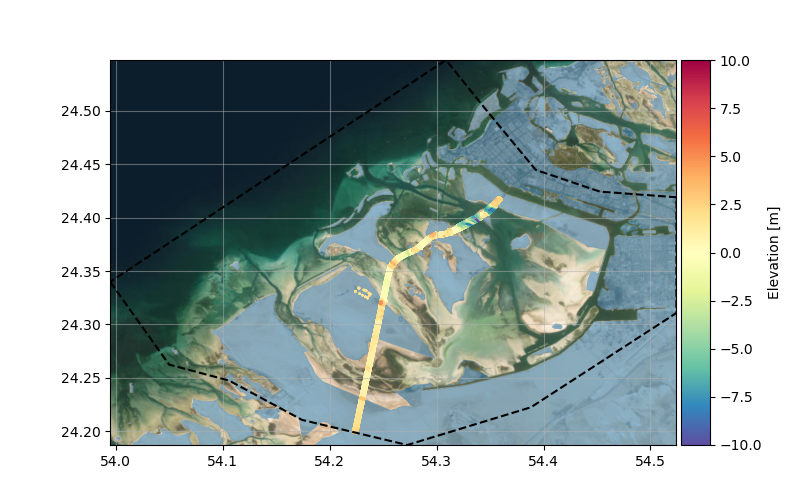

In [59]:
# make plot of in-situ data
#plt.clf() # prevent overflowing the memory

fig, ax = plt.subplots(figsize=(8,5))
ax.grid(alpha=0.5)
ax.plot(AoI.xy[0], AoI.xy[1], 'k--')
gdf_ldb.plot(ax=ax, alpha=0.5)
plot = plt.scatter(gdf_is_fil.x, gdf_is_fil.y, s= 1, c = gdf_is_fil.z, cmap='Spectral_r', vmin=-10, vmax=10) # might need to multiply z with -1 to invert depth
#ax.legend()

# colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = fig.colorbar(plot, shrink=.5, cax=cax)
cb.set_label('Elevation [m]')

# set zoom limits
ax.set_xlim(min(AoI.xy[0]), max(AoI.xy[0]))
ax.set_ylim(min(AoI.xy[1]), max(AoI.xy[1]))

# add imagery basemap
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs="epsg:4326", attribution="")

In [60]:
# define load function for tiff images
def LoadTiff(boxName,tiffName,tiffPath, EPSG = None):
    img = dict()
    b = rasterio.open(os.path.join(tiffPath, boxName, tiffName))
    img['name'] = tiffName
    img['meta'] = b.meta
    img['bandNames'] = b.descriptions
    img['data'] = np.moveaxis(b.read(), [0], [2]) # number of sets to spot 2, the shape (length x width) is on spot 0 and 1
    
    width = img['meta']['width']
    height = img['meta']['height']
    gt = b.get_transform()
    img['gt'] = gt
    minx = gt[0]
    miny = gt[3] + width*gt[4] + height*gt[5] 
    maxx = gt[0] + width*gt[1] + height*gt[2]
    maxy = gt[3]
    img['xdata'] = np.linspace(minx+gt[1]/2, maxx-gt[1]/2, width) # make x array and centerize the pixels
    img['ydata'] = np.flip(np.linspace(miny+gt[1]/2, maxy-gt[1]/2, height)) # make y array and centerize the pixels
    img['Mgrid'] = np.meshgrid(img['xdata'],img['ydata'])
    img['xgridar'] = img['Mgrid'][0].flatten()
    img['ygridar'] = img['Mgrid'][1].flatten()
    img['bounds'] = [minx,maxx,miny,maxy]

    x_tsp, y_tsp = [], []
    if b.crs.to_string().split(":")[-1] != EPSG and EPSG is not None:
        SRC = osr.SpatialReference()
        SRC.ImportFromEPSG(int(b.crs.to_string().split(":")[-1]))
        DST = osr.SpatialReference()
        DST.ImportFromEPSG(int(EPSG))     # WGS84 / Pseudo-Mercator
        SRC_to_DST = osr.CoordinateTransformation(SRC, DST)
        for i, j in zip(img["ygridar"], img["xgridar"]):
            #if np.isnan(k) == False: # only include non-nan values # TODO: fix to be able to work with bigger tiles
            x, y, z = SRC_to_DST.TransformPoint(i, j)
            x_tsp.append(x), y_tsp.append(y)
    img['xgridar_tsp'] = np.array(x_tsp)
    img['ygridar_tsp'] = np.array(y_tsp)
     
    # convert to xarray dataframe
    coords = {'x': img['xdata'], 'y': img['ydata'], 'bands': list(img['bandNames'])}
    img['tiffDF'] = xr.DataArray(img['data'], dims=('y','x','bands'), coords=coords)
    
    return img

In [61]:
# get the intertidal SDB data
images = []
for file in os.listdir(os.path.join(main_fol, input_fol, "TIFF/intertidal")):

    # condition to specify tiling or arbitrary polygons
    if zoom_level == "": cond = "t" # total polygon starts with timesteps directly
    if zoom_level != "": cond = zoom_level  

    if 'xml' not in file and '2021' in file and cond in file.split("_")[0]: # TODO: make filter nicer
        images.append(LoadTiff('',file,os.path.join(main_fol, input_fol, "TIFF/intertidal"), "3857")) # get the image data, also with projected coords

In [62]:
# regression tree to find closest coordinates in the SDB image with relation to the in-situ data (perform once, takes a while
val_data = list(zip(gdf_is_fil_tsp.geometry.centroid.x, gdf_is_fil_tsp.geometry.centroid.y))

# loop over images
SDBI_vals_red, SDBI_xls_red, SDBI_yls_red, is_vals_red, is_xls_red, is_yls_red = [],[],[],[],[],[]
for idx, img in enumerate(images):
    print(idx)
    imagepoints = np.array(list(zip(img["xgridar_tsp"], img["ygridar_tsp"]))) # flat grid points of images 

    # TODO: spin up by doing this for only in-situ points in the same window of the image (sjoin) in case of tiles
    # build the tree (ndist and nind are equal to the length of in-situ data)
    tree = KDTree(imagepoints)
    ndist, nind = tree.query(val_data) # get closest distance and index of the images
    #ndists.append(ndist), ninds.append(nind)

    # get the sorted unqiue values, the first occurence idx, the indices the values match and the number of matches
    nind_val, nind_idx, nind_inv, nind_cnt = np.unique(nind.flatten(), return_index=True, return_inverse=True, return_counts=True)

    # iterate through the list of data to see which connections are made against what distances / points
    distl = [[] for i in range(len(img["xgridar_tsp"]))]
    is_idx = [[] for i in range(len(img["xgridar_tsp"]))]
    dupl_im_idx = [[] for i in range(len(img["xgridar_tsp"]))]
    for idx, (i,j) in enumerate(zip(ndist.flatten(), nind_inv)):
        distl[j].append(i)
        is_idx[j].append(idx)
        dupl_im_idx[j].append(nind_val[j])

    # create reduced lists
    is_idx_new = [] # in-situ data matches idx
    im_idx_new = [] # image data idx
    distl_new = [] # distances between matches points
    for i, j, k in zip(dupl_im_idx, is_idx, distl):
        if len(i) > 0 and np.min(k) < (scale/2): # cap on half the scale to not include points far away
            is_idx_new.append(j[np.argmin(k)]) 
            im_idx_new.append(i[0])
            distl_new.append(np.min(k))

    if len(distl_new) > 0: # check whether there are matches

        # image values
        SDBI_val = list(itemgetter(*list(im_idx_new))(img["data"].flatten()))
        SDB_xl = list(itemgetter(*list(im_idx_new))(img["xgridar"]))
        SDB_yl = list(itemgetter(*list(im_idx_new))(img["ygridar"]))

        # in-situ values
        is_val = list(itemgetter(*list(is_idx_new))(gdf_is_fil_tsp.z))
        is_xl = list(itemgetter(*list(is_idx_new))(gdf_is_fil_tsp.x))
        is_yl = list(itemgetter(*list(is_idx_new))(gdf_is_fil_tsp.y))

        # get rid of Z values that include NaN
        SDBI_val_red = [x for x in SDBI_val if (np.isnan(x) == False)]
        SDBI_val_red_idx = [idx for idx, x in enumerate(SDBI_val) if (np.isnan(x) == False)]

        # reduce other lists with NaN
        SDB_xl_red = np.array(SDB_xl)[SDBI_val_red_idx] 
        SDB_yl_red = np.array(SDB_yl)[SDBI_val_red_idx]  
        is_val_red = np.array(is_val)[SDBI_val_red_idx] 
        is_xl_red = np.array(is_xl)[SDBI_val_red_idx] 
        is_yl_red = np.array(is_yl)[SDBI_val_red_idx]  

        # appending
        SDBI_vals_red.append(np.array(SDBI_val_red)), SDBI_xls_red.append(np.array(SDB_xl_red)), SDBI_yls_red.append(np.array(SDB_yl_red))
        is_vals_red.append(np.array(is_val_red)), is_xls_red.append(np.array(is_xl_red)), is_yls_red.append(np.array(is_yl_red))
    
    else: # append empty
        SDBI_vals_red.append(np.array([])), SDBI_xls_red.append(np.array([])), SDBI_yls_red.append(np.array([]))
        is_vals_red.append(np.array([])), is_xls_red.append(np.array([])), is_yls_red.append(np.array([]))


0


In [64]:
# merging data into one list
SDBI_vals_reds = list(itertools.chain(*SDBI_vals_red))
SDBI_xls_reds = list(itertools.chain(*SDBI_xls_red))
SDBI_yls_reds = list(itertools.chain(*SDBI_yls_red))
is_vals_reds = list(itertools.chain(*is_vals_red)) 
is_xls_reds = list(itertools.chain(*is_xls_red))
is_yls_reds = list(itertools.chain(*is_yls_red))

In [65]:
print(len(SDBI_vals_reds))
print(len(SDBI_xls_reds))
print(len(SDBI_yls_reds))
print(len(is_vals_reds))
print(len(is_xls_reds))
print(len(is_yls_reds))

18528
18528
18528
18528
18528
18528


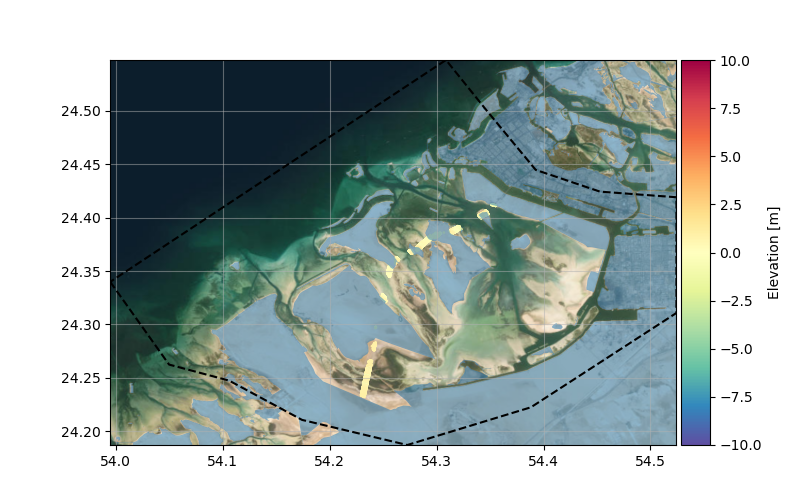

In [66]:
# make plot validation data matched to calibrated SDB data
fig, ax = plt.subplots(figsize=(8,5))
ax.grid(alpha=0.5)
ax.plot(AoI.xy[0], AoI.xy[1], 'k--')
#plot = plt.scatter(gdf_is_fil.x, gdf_is_fil.y, s= 1, c = gdf_is_fil.z*-1, cmap='Spectral_r', vmin=-20, vmax=10) # note the -1 to invert the depth
plot = plt.scatter(is_xls_reds, is_yls_reds, s= 1, c = np.array(is_vals_reds), cmap='Spectral_r', vmin=-10, vmax=10) 
gdf_ldb.plot(ax=ax, alpha=0.5)
#ax.legend()

# colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = fig.colorbar(plot, shrink=.5, cax=cax)
cb.set_label('Elevation [m]')

# set zoom limits
ax.set_xlim(min(AoI.xy[0]), max(AoI.xy[0]))
ax.set_ylim(min(AoI.xy[1]), max(AoI.xy[1]))

# add imagery basemap
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs="epsg:4326", attribution="")

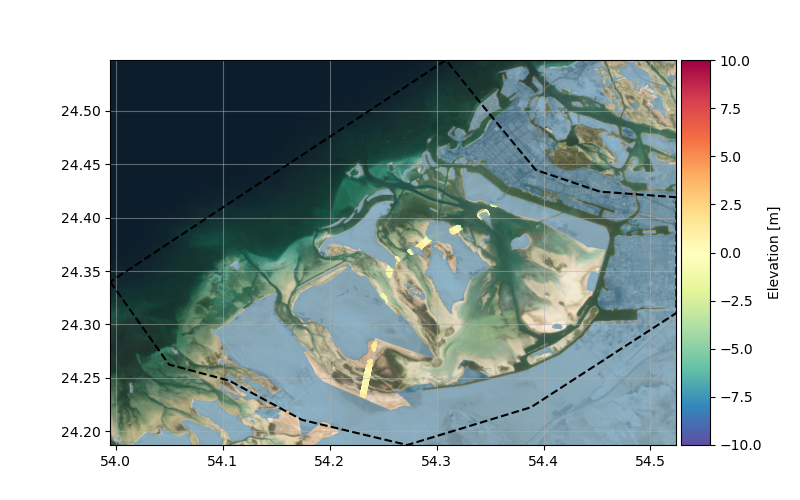

In [67]:
# make plot calibrated intertidal SDB data matched to validation data
fig, ax = plt.subplots(figsize=(8,5))
ax.grid(alpha=0.5)
ax.plot(AoI.xy[0], AoI.xy[1], 'k--')
#plot = plt.scatter(gdf_is_fil.x, gdf_is_fil.y, s= 1, c = gdf_is_fil.z*-1, cmap='Spectral_r', vmin=-20, vmax=10) # note the -1 to invert the depth
plot = plt.scatter(SDBI_xls_reds, SDBI_yls_reds, s= 1, c = np.array(SDBI_vals_reds), cmap='Spectral_r', vmin=-10, vmax=10) 
gdf_ldb.plot(ax=ax, alpha=0.5)
#ax.legend()

# colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = fig.colorbar(plot, shrink=.5, cax=cax)
cb.set_label('Elevation [m]')

# set zoom limits
ax.set_xlim(min(AoI.xy[0]), max(AoI.xy[0]))
ax.set_ylim(min(AoI.xy[1]), max(AoI.xy[1]))

# add imagery basemap
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs="epsg:4326", attribution="")

0.54 0.29 1.74 0.47 0.8


Text(0, 0.5, 'SDB Intertidal data [m]')

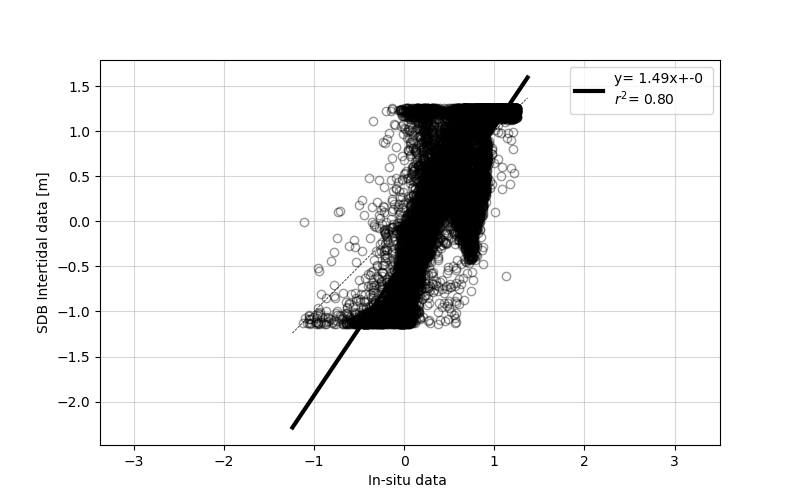

In [68]:
# compute RMSE and correlation plot
RMSE = round(metrics.mean_squared_error(np.array(is_vals_reds), SDBI_vals_reds, squared=False),2)
MSE = round(metrics.mean_squared_error(np.array(is_vals_reds), SDBI_vals_reds, squared=True),2)
ME = round(metrics.max_error(np.array(is_vals_reds), SDBI_vals_reds),2)
MAE = round(metrics.mean_absolute_error(np.array(is_vals_reds), SDBI_vals_reds),2)
lin_fit = scipy.stats.linregress(np.array(is_vals_reds), SDBI_vals_reds)

print(RMSE, MSE, ME, MAE, round(lin_fit.rvalue,2))

fig, ax = plt.subplots(figsize=(8,5))
ax.grid(alpha=0.5)
ax.plot(np.array(is_vals_reds),SDBI_vals_reds,'ko', mfc='none',alpha=0.4)

xmin = plt.xlim()[0]
xmax = plt.xlim()[1]
ax.plot([xmin,xmax],[xmin,xmax],'k--',lw=0.5)

x = np.linspace(xmin,xmax)
ax.plot(x,lin_fit.slope*x+lin_fit.intercept,'k', lw=3,label='%s %.2f%s+%.0f \n%s %.2f' %('y=',lin_fit.slope,'x',lin_fit.intercept,'$r^2$=',lin_fit.rvalue))

ax.axis('equal')
ax.legend()

ax.set_xlabel('In-situ data ')
ax.set_ylabel('SDB Intertidal data [m]')